In [1]:
import requests
import json
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from pynvml import *
import psutil
import os

C:\Users\HP\AppData\Local\Temp\ipykernel_2876\2238081627.py:16: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  from pynvml import *


In [2]:
try:
    df = pd.read_csv("../../test_llm.csv")
except FileNotFoundError:
    print("Error: File 'test_llm.csv' not found.")
    print("Pastikan file tersebut berada di direktori yang sama dengan script ini.")
    exit()

In [3]:
test_df = df.copy()
test_df['label_score'] = test_df['Emotion']

In [4]:
import os
import time
import json
import pandas as pd
from dotenv import load_dotenv, find_dotenv
import psutil
from openai import OpenAI

# =======================================================
# = LOAD API KEY
# =======================================================
dotenv_path = find_dotenv(usecwd=True, raise_error_if_not_found=False)
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print("⚠️ .env tidak ditemukan.")

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# =======================================================
# = RAM MONITOR
# =======================================================
def get_ram_usage_gb():
    return psutil.virtual_memory().used / (1024**3)

def get_vram_usage_gb():
    return 0.0  # Model cloud → VRAM 0

# =======================================================
# = PARAMETER
# =======================================================
emotion_labels = ["Anger", "Fear", "Happy", "Love", "Sadness"]
predictions = []
start_time = time.time()
PENDING_TIMEOUT = 2

model_name = "gpt-5.1"

print(f"🚀 Mulai inferensi dengan model: {model_name}")
print("-" * 50)

# =======================================================
# = LOOP INFERENSI
# =======================================================
for i, row in test_df.iterrows():
    teks = row["Customer Review"]

    # SYSTEM PROMPT
    system_prompt = """
    Anda adalah asisten AI yang ahli dalam analisis emosi pada teks Bahasa Indonesia. 
    Tugas Anda adalah mengklasifikasikan teks pengguna ke dalam salah satu dari 
    5 kelas emosi berikut: Anger, Fear, Happy, Love, dan Sadness.

    Gunakan panduan karakteristik berikut:

    1. ANGER
    - Mengandung kata kasar atau makian.
    - Menunjukkan kemarahan, kekesalan, atau kebencian.
    - Keluhan atau ketidaksukaan terhadap produk/layanan/pengiriman.
    - Menggunakan huruf kapital berlebihan atau tanda baca marah (“!!!”, “???”).
    - Ekspresi jengkel, sebel, atau benci.

    2. FEAR
    - Kalimat peringatan atau rasa takut.
    - Kekhawatiran terhadap produk atau penjual.
    - Keraguan, ketidakpastian, atau menanyakan hal yang membuat cemas.
    - Ekspresi hati-hati, waspada, curiga, atau ragu terhadap keamanan.

    3. HAPPY
    - Mengandung pujian.
    - Kepuasan terhadap produk/penjual.
    - Ekspresi senang, gembira, bahagia, atau puas.
    - Bangga dan memberikan penilaian positif terhadap kualitas produk/penjual.

    4. LOVE
    - Ekspresi perasaan sayang, suka, atau rasa cinta.
    - Sangat puas terhadap produk.
    - Mengandung ungkapan hiperbola/“berlebihan” untuk menyanjung.
    - Mengandung pujian kuat atau kekaguman mendalam.
    - Ekspresi bangga atau sangat menyukai produk/penjual.

    5. SADNESS
    - Menyatakan kekecewaan terhadap produk.
    - Penyesalan, sedih, atau tidak puas.
    - Ekspresi kecewa, menyesal, atau merasa dirugikan.

    Keluaran Anda HARUS berupa JSON dengan format:
    {"emosi": "<Anger/Fear/Happy/Love/Sadness>"}
    """

    user_prompt = f"""
    Teks ulasan berikut: 
    "{teks}"

    Klasifikasikan teks tersebut ke dalam salah satu emosi berikut:
    {', '.join(emotion_labels)}.
    """

    t0 = time.time()

    try:
        # ============================
        # REQUEST OPENAI API
        # ============================
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ],
            response_format={"type": "json_object"}
        )

        # Extract usage metadata
        usage = response.usage
        input_tokens = usage.prompt_tokens if usage else 0
        output_tokens = usage.completion_tokens if usage else 0

        # Parse JSON response
        assistant_text = response.choices[0].message.content.strip()

        try:
            hasil = json.loads(assistant_text)
        except json.JSONDecodeError:
            print(f"[{i}] ⚠️ Gagal parse JSON: {assistant_text}")
            continue

        emosi_pred = hasil.get("emosi", "").capitalize().strip()
        if emosi_pred not in emotion_labels:
            print(f"[{i}] ❌ Emosi tidak valid: {emosi_pred}, fallback → Neutral")
            emosi_pred = "Neutral"

        # Metrics
        latency = time.time() - t0
        ram_usage = get_ram_usage_gb()
        vram_usage = get_vram_usage_gb()

        predictions.append({
            "text": teks,
            "actual": row["Emotion"],
            "predicted": emosi_pred,
            "latency_sec": latency,
            "ram_gb": ram_usage,
            "vram_gb": vram_usage,
            "prompt_tokens": input_tokens,
            "completion_tokens": output_tokens,
        })

        print(f"[{i}] {teks[:50]} → {emosi_pred} | {latency:.2f}s | Tokens: {input_tokens}/{output_tokens}")

        # Delay 10 detik
        print(f"[{i}] 💤 Menunggu {PENDING_TIMEOUT} detik...")
        time.sleep(PENDING_TIMEOUT)

    except Exception as e:
        print(f"[{i}] ❌ Error API OpenAI: {e}")
        continue

# =======================================================
# = RINGKASAN
# =======================================================
end_time = time.time()
total_time = end_time - start_time

if predictions:
    latencies = [p["latency_sec"] for p in predictions]
    lat_no_first = latencies[1:] if len(latencies) > 1 else latencies
    avg_latency = sum(lat_no_first)/len(lat_no_first) if lat_no_first else 0
    throughput = (len(lat_no_first)/sum(lat_no_first))*60 if len(lat_no_first)>1 else 0

    avg_prompt_tokens = sum(p["prompt_tokens"] for p in predictions)/len(predictions)
    avg_completion_tokens = sum(p["completion_tokens"] for p in predictions)/len(predictions)

    avg_ram = sum(p["ram_gb"] for p in predictions)/len(predictions)
    avg_vram = sum(p["vram_gb"] for p in predictions)/len(predictions)

    print("\n" + "="*50)
    print("📊 RINGKASAN EVALUASI")
    print("="*50)
    print(f"Total sampel   : {len(predictions)}")
    print(f"Total waktu    : {total_time:.2f} detik")
    print(f"Avg latency    : {avg_latency:.2f} detik")
    print(f"Throughput     : {throughput:.2f} sampel/menit")
    print("-"*50)
    print(f"Rata2 Prompt Tokens     : {avg_prompt_tokens:.0f}")
    print(f"Rata2 Completion Tokens : {avg_completion_tokens:.0f}")
    print("-"*50)
    print(f"Rata2 RAM usage : {avg_ram:.2f} GB")

    # Simpan CSV
    results_df = pd.DataFrame(predictions)
    results_df.to_csv("results_metrics_emotion_openai.csv", index=False)
    print("✅ Disimpan ke: results_metrics_emotion_openai.csv")

else:
    print("❌ Tidak ada prediksi yang berhasil.")

🚀 Mulai inferensi dengan model: gpt-5.1
--------------------------------------------------
[0] buahnya bagus... kurirnya ok sellernya juga ok → Happy | 2.35s | Tokens: 512/16
[0] 💤 Menunggu 2 detik...
[1] Ada sedikit cacat, selainnya oke → Sadness | 1.65s | Tokens: 507/17
[1] 💤 Menunggu 2 detik...
[2] Jadi semangat mancing. → Happy | 1.09s | Tokens: 505/16
[2] 💤 Menunggu 2 detik...
[3] Cepat tiba n kemasan bagus. barangnya juga bagus → Happy | 1.29s | Tokens: 511/16
[3] 💤 Menunggu 2 detik...
[4] Produk sesuai deskripsi??. Variasi produk beragam. → Happy | 1.05s | Tokens: 515/16
[4] 💤 Menunggu 2 detik...
[5] pelayanan memuaskan dan barang sesuai ?? → Happy | 0.99s | Tokens: 508/16
[5] 💤 Menunggu 2 detik...
[6] Barang bagus dan cepat sekali sampainya ke cianjur → Happy | 1.06s | Tokens: 518/16
[6] 💤 Menunggu 2 detik...
[7] Bagus mantab jernih → Happy | 0.89s | Tokens: 506/16
[7] 💤 Menunggu 2 detik...
[8] trmksh barang sesuai pesanan, fungsi normal... tin → Happy | 1.07s | Tokens: 514/16


In [2]:
results_df = pd.read_csv('results_metrics_emotion_openai.csv')

In [3]:
y_true = results_df["actual"]
y_pred = results_df["predicted"]

In [4]:
report = classification_report(y_true, y_pred, digits=2, zero_division=0)
print("\n=== CLASSIFICATION REPORT ===")
print(report)


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Anger       0.60      0.60      0.60        45
        Fear       1.00      0.02      0.04        45
       Happy       0.60      0.91      0.73        45
        Love       0.89      0.38      0.53        45
     Sadness       0.46      0.93      0.61        45

    accuracy                           0.57       225
   macro avg       0.71      0.57      0.50       225
weighted avg       0.71      0.57      0.50       225



In [5]:
accuracy = accuracy_score(y_true, y_pred)
precision_avg = precision_score(y_true, y_pred, average="macro", zero_division=0)
recall_avg = recall_score(y_true, y_pred, average="macro", zero_division=0)
f1_avg = f1_score(y_true, y_pred, average="macro", zero_division=0)

In [6]:
print(f"Precision avg : {precision_avg:.2f}")
print(f"Recall avg : {recall_avg:.2f}")
print(f"F1 avg : {f1_avg:.2f}")
print(f"Akurasi : {accuracy:.2f}")

Precision avg : 0.71
Recall avg : 0.57
F1 avg : 0.50
Akurasi : 0.57


✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'


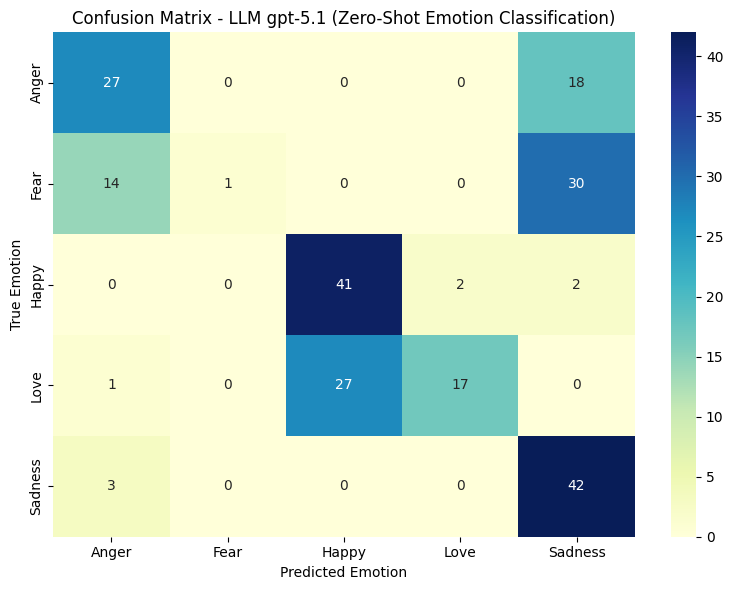

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Buat confusion matrix ===
cm = confusion_matrix(y_true, y_pred, labels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

# === Plot heatmap ===
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'],
            yticklabels=['Anger', 'Fear', 'Happy', 'Love', 'Sadness'])

plt.title("Confusion Matrix - LLM gpt-5.1 (Zero-Shot Emotion Classification)")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.tight_layout()
plt.savefig("confusion_matrix_emotion_llm.png", dpi=300)
print("✅ Confusion matrix disimpan di 'confusion_matrix_emotion_llm.png'")
plt.show()